# Инструменты для работы с языком

... или зачем нужна предобработка.

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Классификацию по тональности используют в рекомендательных системах, чтобы понять, понравилось ли людям кафе, кино, etc.


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [37]:
df_train.shape, df_test.shape

((6929, 2), (794, 2))

In [38]:
df_train.head()

,label,text
0,positive,эти розы для прекрасной мамочки)))=_=]]
1,negative,"И да, у меня в этом году серьезные проблемы со..."
2,positive,"♥Обожаю людей, которые заставляют меня смеятьс..."
3,negative,Вчера нашла в почтовом ящике пустую упаковку и...
4,positive,очень долгожданный и хороший день был)


<AxesSubplot: >

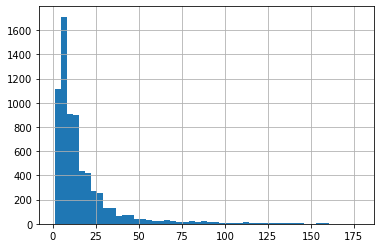

In [98]:
df_train.text.apply(word_tokenize).apply(len).hist(bins=50)

In [41]:
x_train, y_train, x_test, y_test = df_train['text'], df_train['label'], df_test['text'], df_test['label']

In [42]:
y_train

0       positive
1       negative
2       positive
3       negative
4       positive
          ...   
6924    positive
6925    positive
6926    positive
6927    positive
6928    positive
Name: label, Length: 6929, dtype: object

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [43]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы:

In [44]:
from nltk import ngrams

In [45]:
sent = 'Если б мне платили каждый раз'.split()
list(ngrams(sent, 1)) # униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

In [46]:
list(ngrams(sent, 2)) # биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [47]:
list(ngrams(sent, 3)) # триграммы

[('Если', 'б', 'мне'),
 ('б', 'мне', 'платили'),
 ('мне', 'платили', 'каждый'),
 ('платили', 'каждый', 'раз')]

In [48]:
list(ngrams(sent, 5)) # ... пентаграммы?

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

Приведем к нижнему регистру

In [49]:
x_train = x_train.str.lower()
x_test = x_test.str.lower()

In [50]:
x_train.shape, x_test.shape

((6929,), (794,))

In [51]:
x_train

0                 эти розы для прекрасной мамочки)))=_=]]
1       и да, у меня в этом году серьезные проблемы со...
2       ♥обожаю людей, которые заставляют меня смеятьс...
3       вчера нашла в почтовом ящике пустую упаковку и...
4                  очень долгожданный и хороший день был)
                              ...                        
6924    ссора. я: я не твоя жена, чтобы ты мог мне зап...
6925                                  к\nр\nа\nс\nу\nн\nя
6926    опять улетаю сегодня в ночь, до 30 не будет в ...
6927    хватит гарусных статусов!!!!!лето!!!)))пора на...
6928                    ахахахахахах! !!! лёва помнишь???
Name: text, Length: 6929, dtype: object

Самый простой способ извлечь фичи из текстовых данных -- векторизаторы: CountVectorizer и TfidfVectorizer

Объект CountVectorizer делает очень простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности n, где n -- количество слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

In [56]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words

ngram_range отвечает за то, какие n-граммы мы используем в качестве фичей:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

В vec.vocabulary_ лежит словарь: мэппинг слов к их индексам:

In [55]:
list(vec.vocabulary_.items())[:10]

[('эти', 78958),
 ('розы', 58767),
 ('для', 15893),
 ('прекрасной', 53692),
 ('мамочки', 31886),
 ('эти розы', 78992),
 ('розы для', 58768),
 ('для прекрасной', 15975),
 ('прекрасной мамочки', 53695),
 ('да', 13988)]

In [57]:
bow

<6929x22497 sparse matrix of type '<class 'numpy.int64'>'
	with 70895 stored elements in Compressed Sparse Row format>

In [58]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

LogisticRegression(random_state=42)

In [59]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.53      0.81      0.64       171
    positive       0.94      0.81      0.87       623

    accuracy                           0.81       794
   macro avg       0.74      0.81      0.76       794
weighted avg       0.85      0.81      0.82       794



Попробуем сделать то же самое для триграмм:

In [62]:
vec = CountVectorizer(ngram_range=(1, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.48      0.76      0.59       163
    positive       0.93      0.79      0.85       631

    accuracy                           0.78       794
   macro avg       0.70      0.77      0.72       794
weighted avg       0.84      0.78      0.80       794



## TF-IDF векторизация

TfidfVectorizer делает то же, что и CountVectorizer, но в качестве значений – tf-idf каждого слова.

Как считается tf-idf:

tf (term frequency) – относительная частотность слова в документе:
$$ tf(t,d) = \frac{n_{t}}{\sum_k n_{k}} $$

idf (inverse document frequency) – обратная частота документов, в которых есть это слово:
$$ idf(t, D) = \mbox{log} \frac{|D|}{|{d : t \in d}|} $$

Потом просто их перемножаем:
$$tfidf_(t,d,D) = tf(t,d) \times idf(i, D)$$

Сакральный смысл – если слово часто встречается в одном документе, но в целом по корпусу встречается в небольшом 
количестве документов, у него высокий TF-IDF.

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.48      0.79      0.60       155
    positive       0.94      0.79      0.86       639

    accuracy                           0.79       794
   macro avg       0.71      0.79      0.73       794
weighted avg       0.85      0.79      0.81       794



В этот раз получилось хуже :( Вернёмся к CountVectorizer.

In [67]:
x_train[0].split()

['эти', 'розы', 'для', 'прекрасной', 'мамочки)))=_=]]']

## Токенизация

По дефолту векторизаторы используют свои *токенизаторы*, но можно это изменить, задав аргумент `tokenizer`.

Самый наивный способ токенизировать текст -- разделить с помощью `split`. Но `split` упускает очень много всего, например, банально не отделяет пунктуацию от слов. Кроме этого, есть ещё много менее тривиальных проблем. Поэтому лучше использовать готовые токенизаторы.

In [68]:
from nltk.tokenize import word_tokenize

In [69]:
example = 'Но не каждый хочет что-то исправлять:('
word_tokenize(example)

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять', ':', '(']

В nltk вообще есть довольно много токенизаторов:

In [73]:
from nltk import tokenize
dir(tokenize)

['BlanklineTokenizer',
 'LegalitySyllableTokenizer',
 'LineTokenizer',
 'MWETokenizer',
 'NLTKWordTokenizer',
 'PunktSentenceTokenizer',
 'RegexpTokenizer',
 'ReppTokenizer',
 'SExprTokenizer',
 'SpaceTokenizer',
 'StanfordSegmenter',
 'SyllableTokenizer',
 'TabTokenizer',
 'TextTilingTokenizer',
 'ToktokTokenizer',
 'TreebankWordDetokenizer',
 'TreebankWordTokenizer',
 'TweetTokenizer',
 'WhitespaceTokenizer',
 'WordPunctTokenizer',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_treebank_word_tokenizer',
 'api',
 'blankline_tokenize',
 'casual',
 'casual_tokenize',
 'destructive',
 'legality_principle',
 'line_tokenize',
 'load',
 'mwe',
 'punkt',
 're',
 'regexp',
 'regexp_span_tokenize',
 'regexp_tokenize',
 'repp',
 'sent_tokenize',
 'sexpr',
 'sexpr_tokenize',
 'simple',
 'sonority_sequencing',
 'stanford_segmenter',
 'string_span_tokenize',
 'texttiling',
 'toktok',
 'treebank',
 'util',
 'word_tok

Они умеют выдавать индексы начала и конца каждого токена:

In [79]:
wh_tok = tokenize.WhitespaceTokenizer()
list(wh_tok.span_tokenize(example))

[(0, 2), (3, 5), (6, 12), (13, 18), (19, 25), (26, 38)]

(если вам было интересно, зачем вообще включать в модуль токенизатор, который работает как `.split()` :))

Некторые токенизаторы ведут себя специфично:

In [75]:
tokenize.TweetTokenizer().tokenize("don't stop me:)")

["don't", 'stop', 'me', ':)']

Для некоторых задач это может быть полезно.

А некоторые -- вообще не для текста на естественном языке (не очень понятно, зачем это в nltk :)):

In [72]:
tokenize.SExprTokenizer().tokenize("(a (b c)) d e (f)")

['(a (b c))', 'd', 'e', '(f)']

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [76]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
from nltk.corpus import stopwords
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [77]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [78]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [79]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.52      0.83      0.63       161
    positive       0.95      0.80      0.87       633

    accuracy                           0.81       794
   macro avg       0.73      0.81      0.75       794
weighted avg       0.86      0.81      0.82       794



Получилось чууть лучше. Что ещё можно сделать?

## Лемматизация

Лемматизация – это сведение разных форм одного слова к начальной форме – *лемме*. Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельную фичу каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

Для русского есть два хороших лемматизатора: mystem и pymorphy:

### [Mystem](https://tech.yandex.ru/mystem/)
Как с ним работать:
* можно скачать mystem и запускать [из терминала с разными параметрами](https://tech.yandex.ru/mystem/doc/)
* [pymystem3](https://pythonhosted.org/pymystem3/pymystem3.html) - обертка для питона, работает медленнее, но это удобно

In [84]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Мы инициализировали Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin - путь к `mystem`, если их несколько
* grammar_info - нужна ли грамматическая информация или только леммы (по дефолту нужна)
* disambiguation - нужно ли снятие омонимии - дизамбигуация (по дефолту нужна)
* entire_input - нужно ли сохранять в выводе все (пробелы всякие, например), или можно выкинуть (по дефолту оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

Можно просто лемматизировать текст:

In [85]:
print(mystem_analyzer.lemmatize(example))

['но', ' ', 'не', ' ', 'каждый', ' ', 'хотеть', ' ', 'что-то', ' ', 'исправлять', ':(\n']


А можно получить грамматическую информацию:

In [86]:
mystem_analyzer.analyze(example)

[{'analysis': [{'lex': 'но', 'wt': 0.9998906299, 'gr': 'CONJ='}],
  'text': 'Но'},
 {'text': ' '},
 {'analysis': [{'lex': 'не', 'wt': 1, 'gr': 'PART='}], 'text': 'не'},
 {'text': ' '},
 {'analysis': [{'lex': 'каждый',
    'wt': 0.9985975799,
    'gr': 'APRO=(вин,ед,муж,неод|им,ед,муж)'}],
  'text': 'каждый'},
 {'text': ' '},
 {'analysis': [{'lex': 'хотеть',
    'wt': 1,
    'gr': 'V,несов,пе=непрош,ед,изъяв,3-л'}],
  'text': 'хочет'},
 {'text': ' '},
 {'analysis': [{'lex': 'что-то', 'wt': 1, 'gr': 'SPRO,ед,сред,неод=(вин|им)'}],
  'text': 'что-то'},
 {'text': ' '},
 {'analysis': [{'lex': 'исправлять', 'wt': 1, 'gr': 'V,пе=инф,несов'}],
  'text': 'исправлять'},
 {'text': ':(\n'}]

Давайте терепь лемматизатор майстема в качестве токенизатора.

In [87]:
import re

def my_preproc(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word not in stopwords.words('russian') + [' ', '\n']]

In [88]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.57      0.85      0.69       174
    positive       0.95      0.82      0.88       620

    accuracy                           0.83       794
   macro avg       0.76      0.84      0.78       794
weighted avg       0.87      0.83      0.84       794



### [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [69]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

pymorphy2 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [72]:
ana = pymorphy2_analyzer.parse(sent[3])
ana

[Parse(word='платили', tag=OpencorporaTag('VERB,impf,tran plur,past,indc'), normal_form='платить', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'платили', 2368, 10),))]

In [82]:
ana[0].normal_form

'платить'

А теперь напишите аналогичную функцию для лемматизации с pymorphy2:

Что будет, если использовать её в качестве препроцессора? 

### mystem vs. pymorphy

1) *Мы надеемся, что вы пользуетесь линуксом*, но mystem работает невероятно медленно под windows на больших текстах.

2) *Снятие омонимии*. Mystem умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy2 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту:

In [24]:
homonym1 = 'За время обучения я прослушал больше сорока курсов.'
homonym2 = 'Сорока своровала блестящее украшение со стола.'
mystem_analyzer = Mystem() # инициализирую объект с дефолтными параметрами

print(mystem_analyzer.analyze(homonym1)[-5])
print(mystem_analyzer.analyze(homonym2)[0])

{'text': 'сорока', 'analysis': [{'gr': 'NUM=(пр|дат|род|твор)', 'lex': 'сорок'}]}
{'text': 'Сорока', 'analysis': [{'gr': 'S,жен,од=им,ед', 'lex': 'сорока'}]}


## Словарь, закон Ципфа и закон Хипса

Закон Ципфа -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

In [15]:
from collections import Counter

In [25]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2859142


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [26]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69267),
 ('и', 54916),
 ('в', 52853),
 ('я', 52506),
 ('RT', 38070),
 ('на', 35715),
 ('http', 32992),
 ('что', 31472),
 ('...', 28773),
 ('с', 27176)]

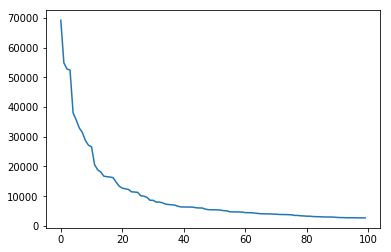

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [89]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.70      0.81      0.75       223
    positive       0.92      0.86      0.89       571

    accuracy                           0.85       794
   macro avg       0.81      0.84      0.82       794
weighted avg       0.86      0.85      0.85       794



Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите фичи с самыми большими коэффициэнтами:

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [37]:
cool_token = 
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       1.00      0.85      0.92     32733
   positive       0.83      1.00      0.91     23976

avg / total       0.93      0.91      0.91     56709



## Символьные n-граммы

Теперь в качестве фичей используем, например, униграммы символов:

In [90]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.44      0.79      0.57       145
    positive       0.94      0.78      0.85       649

    accuracy                           0.78       794
   macro avg       0.69      0.78      0.71       794
weighted avg       0.85      0.78      0.80       794



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


В общем-то, теперь уже понятно, почему на этих данных здесь 1. Просто знайте, что так можно: для некторых задач (например, для определения языка) фичи-символьные n-граммы решительно рулят.

Ещё одна замечательная особенность фичей-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готвых анализаторов.

## fastText

https://fasttext.cc/docs/en/supervised-tutorial.html

Если осталось время -- сами поизучайте этот модуль и попробуйти применить его к нашей задаче.